# Hack the gap!

## Exploring UK gender pay gap data with Data + Women, London

Extension: pivot the data with groupby, clean and join, interactive plots

Tutorial by Christine Dixon April 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('UK Gender Pay Gap Data - 2018 to 2019.csv')

In [3]:
# Make a new column to get the % female in each quartile
df['PercentFemale'] = df.iloc[:,[11,13,15,17]].sum(axis=1)
df['PercentFemale'] = df['PercentFemale']/4

## Part 4: using .groupby()

### Building a groupby statement:
<br>

step 1: select the column(s) you want in your results
    
    df['colname']
    
    
<br> 
step 2: select the column that has the data categories
    
    df['colname'].groupby(df['column2'])  
    
    
<br>  
step 3: choose what statistic or function you want to apply to the grouped data

    df['colname'].groupby(df['column2']).min()
    

<br>
More complex: You can select a list of columns and apply several aggregate functions by passing a list to the .agg() function (remember lists need square brackets [ ])

    df[['col1','col2']].groupby(df['column2']).agg(['count','sum','std','sem','max','min'])

In [4]:
df['DiffMedianHourlyPercent'].head(4)

0    12.7
1    12.7
2    -2.0
3     2.1
Name: DiffMedianHourlyPercent, dtype: float64

In [5]:
# The due date is earlier for non-profit companies.
# We can use this to compare the wage gap at non-profits to private sector companies
# Will the private sector have a larger average pay gap?

df['DateSubmitted'].unique()

array(['06/03/2019 13:26:24', '18/03/2019 14:03:16',
       '11/02/2019 16:30:41', ..., '04/03/2019 09:37:57',
       '21/03/2019 10:38:32', '22/03/2019 15:50:22'], dtype=object)

In [6]:
# We can see that about 15% of the companies have the non-profit due date

df['DueDate'].value_counts()

05/04/2019 00:00:00    4502
31/03/2019 00:00:00    1596
Name: DueDate, dtype: int64

In [7]:
# The magic part: this makes a groupby object that has grouped your data by the selected column

df['DiffMedianHourlyPercent'].groupby(by=df['DueDate'])

In [8]:
df['DiffMeanHourlyPercent'].groupby(df['DueDate']).agg(['min', 'max', 'mean', 'sem'])

,min,max,mean,sem
DueDate,,,,
05/04/2019 00:00:00,-65.0,91.7,13.638872,0.218517
31/03/2019 00:00:00,-18.0,57.0,14.909336,0.252559


## Part 5: Joining spreadsheets
## How does the gap vary by industry?

In [9]:
# Import the table of SIC codes which will give you more information about the companies
# We will add this information as a new column in our pay gap df

sic_df = pd.read_csv('SIC07_CH_condensed_list_en.csv', index_col='SIC Code')

In [10]:
# It won't be spossible to join the raw pay gap df because there are letters mixed in with the SIC codes
# Lots of companies have listed more than one code

In [11]:
# How many companies are listed with each SIC code?

df['SicCodes'].value_counts()

1,\r\n84110                            343
82990                                  232
1,\r\n85310                            221
1,\r\n86210                            208
1                                      155
70100                                  120
78200                                  117
1,\r\n85200,\r\n85310                  109
1,\r\n85320                            107
86900                                   89
1,\r\n85421                             82
56102                                   73
1,\r\n85200                             62
96090                                   61
49319                                   59
64999                                   52
55100                                   50
32990                                   49
1,\r\n85590                             44
85310                                   44
62090                                   42
1,\r\n84240                             41
1,\r\n85100,\r\n85200,\r\n85310         40
56101      

In [12]:
# Using a regex to extract the numerical information we need
df['SicCodes'] = df['SicCodes'].str.extract(r'(\d+)')

# Can we turn the column into an integer now?
# df['SicCodes'] = df['SicCodes'].astype('int')

In [13]:
# Null values prevent us from treating these data as integers
len(df[df['SicCodes'].isnull()])

270

In [14]:
# we can get rid of null values by making them 0
df.loc[df['SicCodes'].isnull(), 'SicCodes'] = 0

In [15]:
len(df[df['SicCodes'].isnull()])

0

In [16]:
# Now we are ready to make our siccode column into an integer
df['SicCodes'] = df.loc[:,'SicCodes'].astype('int')

In [17]:
# Does the join work now?
df = df.join(sic_df, on='SicCodes', how='left')

# Note: if you try to run this cell a 2nd time it will throw an error because the column already exists!

In [18]:
# Do industries with a higher % female have higher mean hourly pay gaps

industry_summary = df[['DiffMeanHourlyPercent','DiffMedianHourlyPercent','PercentFemale']].groupby(df['Description']).agg(['count','mean','sem'])

In [19]:
industry_summary.sample(3)

DiffMeanHourlyPercent  \
                                                                   count   
Description                                                                
Ready-made interactive leisure and entertainmen...                     2   
Manufacture of women's underwear                                       1   
Regulation of health care, education, cultural ...                     1   

                                                                \
                                                    mean   sem   
Description                                                      
Ready-made interactive leisure and entertainmen...  10.3  17.8   
Manufacture of women's underwear                    39.1   NaN   
Regulation of health care, education, cultural ...   2.0   NaN   

                                                   DiffMedianHourlyPercent  \
                                                                     count   
Description                                                                  
Ready-made interactive leisure and entertainmen...                       2   
Manufacture of women's underwear                                         1   
Regulation of health care, education, cultural ...                       1   

                                                                  \
                                                     mean    sem   
Description                                                        
Ready-made interactive leisure and entertainmen...   4.35  19.15   
Manufacture of women's underwear                    37.10    NaN   
Regulation of health care, education, cultural ...  -3.00    NaN   

                                                   PercentFemale               
                                                           count    mean  sem  
Description                                                                    
Ready-made interactive leisure and entertainmen...             2  14.575  3.9  
Manufacture of women's underwear                               1  82.300  NaN  
Regulation of health care, education, cultural ...             1  73.125  NaN

In [20]:
# Select only industry categories with a decent number of companies e.g. more than 20

to_plot = industry_summary.loc[industry_summary['DiffMeanHourlyPercent','count'] > 20]
to_plot.head(2)

DiffMeanHourlyPercent             \
                                                             count       mean   
Description                                                                     
Activities of head offices                                     131  19.676336   
Activities of other holding companies n.e.c.                    24  10.170833   

                                                        \
                                                   sem   
Description                                              
Activities of head offices                    1.372874   
Activities of other holding companies n.e.c.  3.475496   

                                             DiffMedianHourlyPercent  \
                                                               count   
Description                                                            
Activities of head offices                                       131   
Activities of other holding companies n.e.c.                      24   

                                                                   \
                                                   mean       sem   
Description                                                         
Activities of head offices                    15.866412  1.301451   
Activities of other holding companies n.e.c.   6.987500  4.763369   

                                             PercentFemale             \
                                                     count       mean   
Description                                                             
Activities of head offices                             131  42.170802   
Activities of other holding companies n.e.c.            24  40.816667   

                                                        
                                                   sem  
Description                                             
Activities of head offices                    1.535441  
Activities of other holding companies n.e.c.  4.055040

In [21]:
len(to_plot)

48

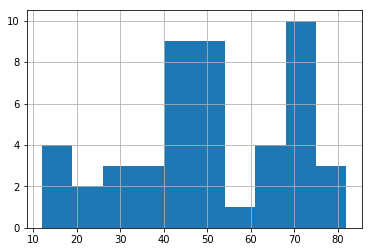

In [22]:
# Quick histogram: for industries with 20+ companies
# 
to_plot['PercentFemale','mean'].hist(bins=10)

## Plotting the data

In [23]:
xdata = to_plot['PercentFemale','mean']
ydata = to_plot['DiffMeanHourlyPercent','mean']

xerr = to_plot['PercentFemale','sem']
yerr = to_plot['DiffMeanHourlyPercent','sem']

Text(0, 0.5, 'Mean Gap (%)')

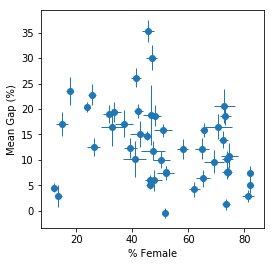

In [24]:
plt.figure(figsize=(4,4))

plt.plot(x=xdata, y=ydata)

plt.errorbar(x=xdata, y=ydata, 
             xerr=xerr, yerr=yerr, fmt='o',elinewidth=1, alpha=1)
plt.xlabel('% Female')
plt.ylabel('Mean Gap (%)')


In [25]:
# Is there a correlation between the gender balance of the sector and the pay gap?
# The list of columns now requires tuples (upperCol, lowerCol) for the multi index

to_plot[[('DiffMeanHourlyPercent','mean'), ('PercentFemale', 'mean')]].corr()

,,DiffMeanHourlyPercent,PercentFemale
,,mean,mean
DiffMeanHourlyPercent,mean,1.000000,-0.303854
PercentFemale,mean,-0.303854,1.000000


In [26]:
# Industries with more women have a smaller pay gap

df[['DiffMeanHourlyPercent', 'PercentFemale']].corr() 
# For individual companies, %female correlates poorly with gap
# This means that there is a lot of pay gap variation within industry sectors

,DiffMeanHourlyPercent,PercentFemale
DiffMeanHourlyPercent,1.000000,0.059647
PercentFemale,0.059647,1.000000


## Part 6: Make an interactive plot!

In [27]:
# To interact with this plot:

import matplotlib.animation as animation

%matplotlib notebook

<IPython.core.display.Javascript object>


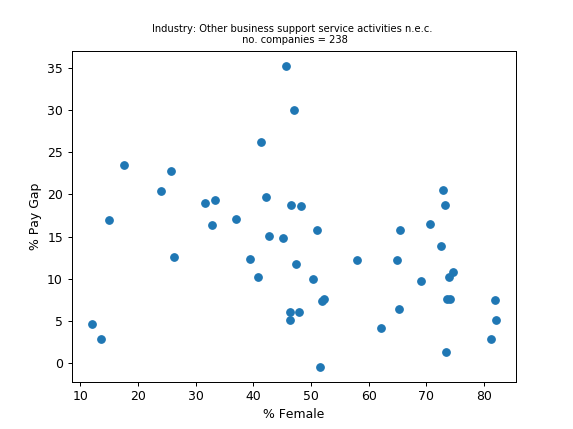

6

In [28]:
plt.figure()
plt.scatter(xdata, ydata, picker=2) #picker specifies no. pixels away from data point
plt.gca().set_xlabel('% Female')
plt.gca().set_ylabel('% Pay Gap')

def onpick(event):
    '''Listens for click near data point; finds & displays relevant info'''
    origin = to_plot.index[event.ind[0]]
    n = to_plot.iloc[event.ind[0]]['PercentFemale','count'].astype(int)
    plt.gca().set_title('Industry: {} \n no. companies = {}'.format(origin, n), size=8)

# this line wires it up: now you can click on the chart
plt.gcf().canvas.mpl_connect('pick_event', onpick)

<IPython.core.display.Javascript object>


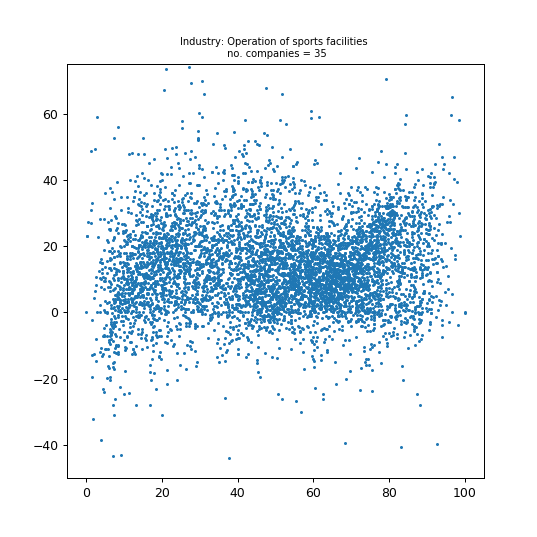

6

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(df['PercentFemale'], df['DiffMeanHourlyPercent'], marker='o', s=2, picker=10)
plt.ylim(-50, +75)

def onpick2(event):
    '''Listens for click near data point; finds & displays relevant info'''
    company = df.iloc[event.ind[0]]['EmployerName']
    industry = df.iloc[event.ind[0]]['Description']
    plt.gca().set_title('{} \n {}'.format(company, industry), size=8)

plt.gcf().canvas.mpl_connect('pick_event', onpick2)